In [248]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import string
import nltk
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

#nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_columns', None)
df = pd.read_csv('labeled_data.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Preprocessing and visualization



### tweet is the sentence to be reviewed 
### count is the number of people who reviewd the sentence
### hate_speech/offensive_language/neither count how many reviewers found a sentnce a specific type
### class is the final classification of the sentece based on the majority vote (target)


In [249]:
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [250]:
df.drop(columns='Unnamed: 0' , inplace=True)#drop useless index column
df.head()


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## hate_speech/offensive_language/neither are encapsulated fully by the final class

In [251]:
df.drop(columns=['count','hate_speech', 'offensive_language','neither'] , inplace=True)#drop useless columns
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [252]:
#check null values
df.isnull().sum() 

class    0
tweet    0
dtype: int64

# Preprocessing sentences


In [253]:
stopwords = nltk.corpus.stopwords.words("english")#stop words are words that appear in sentences that do not affect the outcome of the meaning

other_exclusions = ["#ff", "ff", "rt" , "RT"]#adding common twitter words to the stop words to remove
stopwords.extend(other_exclusions)
def preprocess(tweet):  
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ' , regex=True)
    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '' , regex=True)
    # removal of links[https://abc.com]
    giant_url_regex =  re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '', regex=True)
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace(r"[^a-zA-Z]", " ", regex=True)
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ', regex=True)
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','', regex=True)
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr', regex=True)
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    return tweets_p
processed_tweets = preprocess(df.tweet)   
df['processed_tweets'] = processed_tweets
print(df[["tweet","processed_tweets"]].head(10))

                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
6  !!!!!!"@__BrighterDays: I can not just sit up ...   
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
8  " &amp; you might not get ya bitch back &amp; ...   
9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                    processed_tweets  
0  woman complain cleaning house amp man always t...  
1  boy dats cold tyga dwn bad cuffin dat hoe st p...  
2       dawg ever fuck bitch start cry confused shit  
3                                   look like tranny  
4     shit hear might true might faker bitch told ya  
5  shit blows claim faithful somebody still fucki... 

# class 0 -> HateSpeech
# class 1 -> Offesnive
# class 3 -> neither

<Axes: xlabel='class', ylabel='count'>

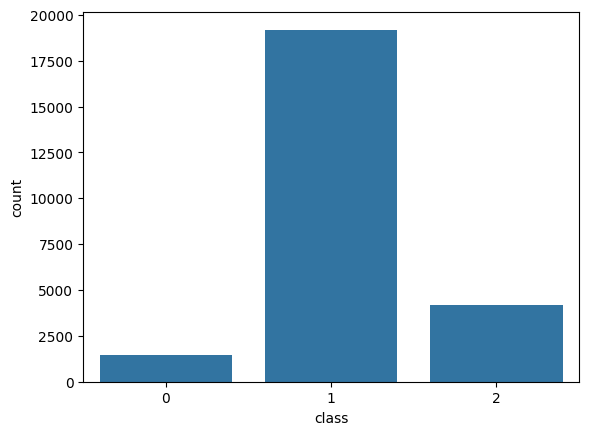

In [254]:
sns.countplot(x='class' , data= df )

In [255]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

### majority of classification is skwewed towards offensive


# Word visualizations


All words

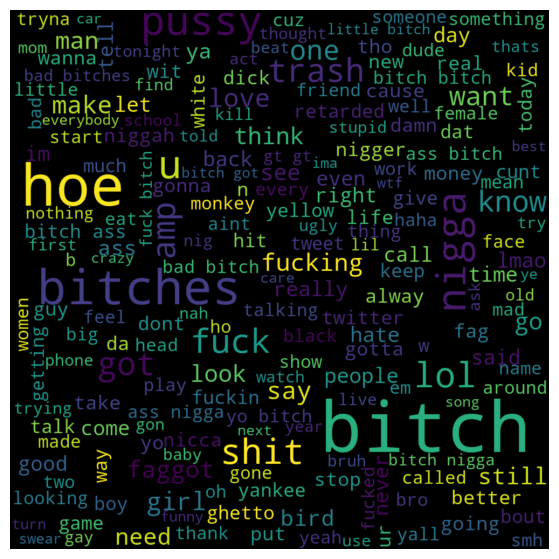

In [256]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_words = ' '.join([text for text in df['processed_tweets'] ])
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=130).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Offensive words

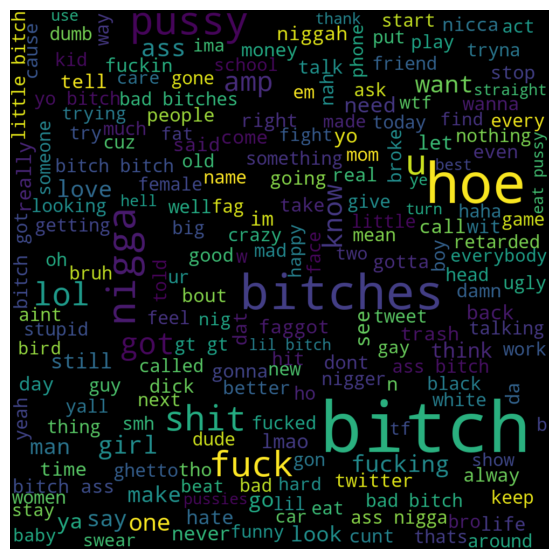

In [257]:

all_words = ' '.join([text for text in df['processed_tweets'][df['class']== 1] ])
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=130).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

HateSpeech words

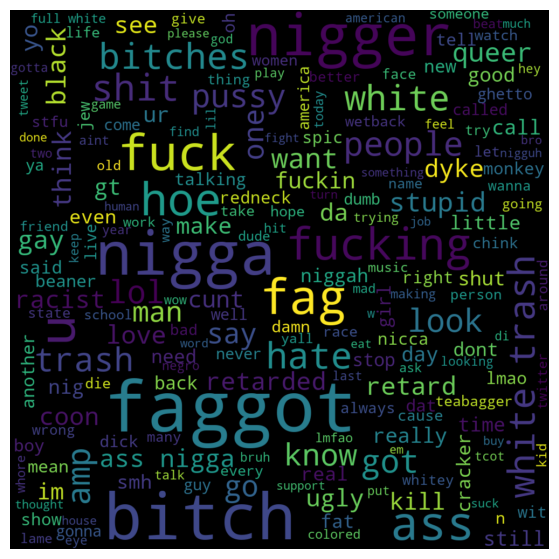

In [258]:

all_words = ' '.join([text for text in df['processed_tweets'][df['class']== 0] ])
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=130).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Normal Words

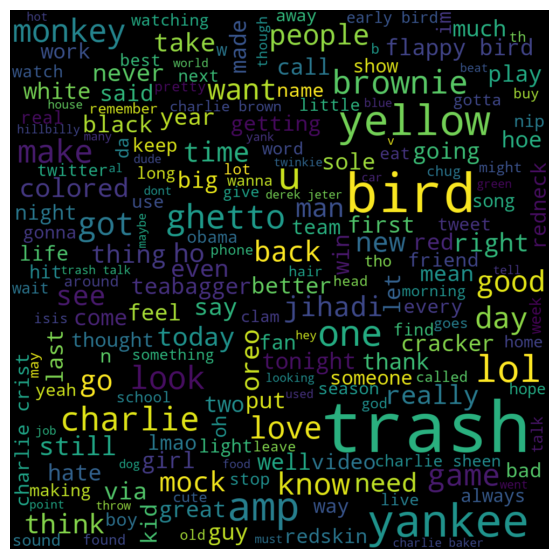

In [259]:

all_words = ' '.join([text for text in df['processed_tweets'][df['class']== 2] ])
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=130).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Logestic regression

### without tuning and addressing skew

In [260]:
# X = df[['processed_tweets']]
# y = df['class']

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



# # Convert text to numerical features , tfidf gives each word a score based on the frequency of occurence
# tfidf_vectorizer = TfidfVectorizer( max_features=1000 , ngram_range=(1,2))#consider words inidividually but also consider combinations of words
# X_train = tfidf_vectorizer.fit_transform(X_train['processed_tweets'])
# X_test = tfidf_vectorizer.transform(X_test['processed_tweets'])


# #model training
# clf =  LogisticRegression(C = 1, random_state= 42)
# clf.fit(X_train, y_train)

# # Make predictions
# predictions = clf.predict(X_test)

# # Evaluation
# accuracy = accuracy_score(y_test, predictions)
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_test, predictions))

### To combat imbalance(most classifications skewed towards offensive) , resampling and stratifed kfolding, we also use grid search to find best parameters for the model

In [262]:
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

df_major = df[df['class'] == 1]
df_minor1 = df[df['class'] == 0]
df_minor2 = df[df['class'] == 2]

# oversample minority classes
df_minor1_upsampled = resample(df_minor1, replace=True, n_samples=len(df_major), random_state=42)
df_minor2_upsampled = resample(df_minor2, replace=True, n_samples=len(df_major), random_state=42)

# combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_major, df_minor1_upsampled, df_minor2_upsampled])

X = df_upsampled['processed_tweets']
y = df_upsampled['class']

# Convert text to numerical features #2250
tfidf_vectorizer = TfidfVectorizer(max_features=2250, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(X)

# parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Initialize the classifier with GridSearchCV
clf = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=skf)
clf.fit(X, y)

# best C for logestic regressi:
print(clf.best_params_)
final_logestic_model = LogisticRegression(C=clf.best_params_['C'], max_iter=10000)
final_logestic_model.fit(X, y)



{'C': 100}


LogisticRegression(C=100, max_iter=10000)

Accuracy: 0.933993399339934
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     19190
           1       0.96      0.85      0.90     19190
           2       0.95      0.98      0.97     19190

    accuracy                           0.93     57570
   macro avg       0.94      0.93      0.93     57570
weighted avg       0.94      0.93      0.93     57570



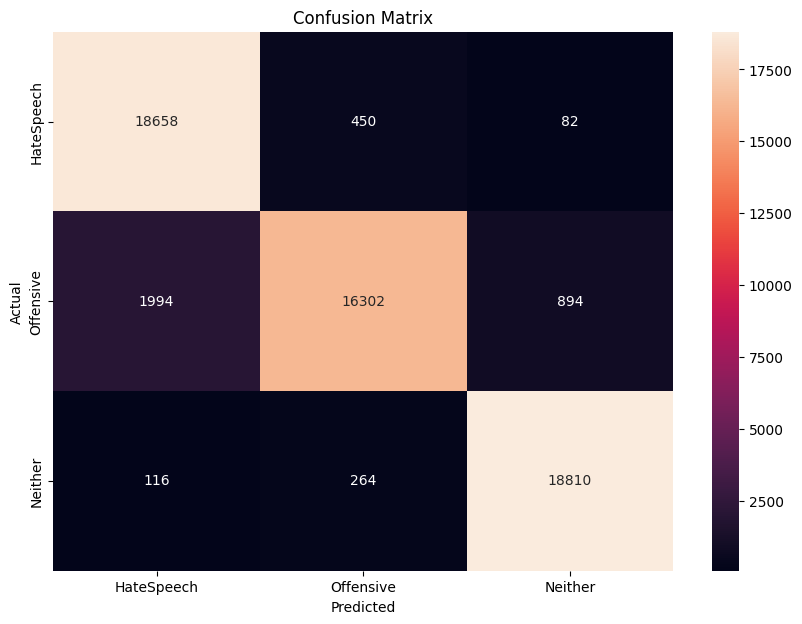

In [264]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(final_logestic_model, X, y, cv=skf)

# Print the accuracy score
print("Accuracy:", accuracy_score(y, y_pred))

print(classification_report(y, y_pred))

cf_matrix = confusion_matrix(y, y_pred)

cf_matrix_df = pd.DataFrame(cf_matrix, index=['HateSpeech', 'Offensive', 'Neither'], columns=['HateSpeech', 'Offensive', 'Neither'])

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cf_matrix_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




In [305]:
# Example sentence
new_sentence = pd.Series("black people are good")

new_sentence = preprocess(new_sentence)
print(new_sentence)


# Convert the new sentence to TF-IDF features
new_sentence_tfidf = tfidf_vectorizer.transform([new_sentence[0]])

# Make predictions for the new sentence
prediction = final_logestic_model.predict(new_sentence_tfidf)

# Print the prediction
classifciationType = ''
if(prediction[0] == 0):
    classifciationType = 'Hate Speech'
elif(prediction[0] == 1): 
        classifciationType = 'Offesnive'
elif(prediction[0]==2):
        classifciationType = 'Neither'


print(f"The prediction for the sentence is: {classifciationType}")

0    black people good
dtype: object
The prediction for the sentence is: Neither


# Web Scrapping

In [9]:
import pandas as pd
from tqdm.notebook import tqdm
import snscrape.modules.twitter as sntwitter
scrapper=sntwitter.TwitterSearchScraper("#battle_bots")
for tweet in scrapper.get_items():
    break


Error retrieving https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22%23battle_bots%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api

ScraperException: 4 requests to https://twitter.com/i/api/graphql/7jT5GT59P8IFjgxwqnEdQw/SearchTimeline?variables=%7B%22rawQuery%22%3A%22%23battle_bots%22%2C%22count%22%3A20%2C%22product%22%3A%22Latest%22%2C%22withDownvotePerspective%22%3Afalse%2C%22withReactionsMetadata%22%3Afalse%2C%22withReactionsPerspective%22%3Afalse%7D&features=%7B%22rweb_lists_timeline_redesign_enabled%22%3Afalse%2C%22blue_business_profile_image_shape_enabled%22%3Afalse%2C%22responsive_web_graphql_exclude_directive_enabled%22%3Atrue%2C%22verified_phone_label_enabled%22%3Afalse%2C%22creator_subscriptions_tweet_preview_api_enabled%22%3Afalse%2C%22responsive_web_graphql_timeline_navigation_enabled%22%3Atrue%2C%22responsive_web_graphql_skip_user_profile_image_extensions_enabled%22%3Afalse%2C%22tweetypie_unmention_optimization_enabled%22%3Atrue%2C%22vibe_api_enabled%22%3Atrue%2C%22responsive_web_edit_tweet_api_enabled%22%3Atrue%2C%22graphql_is_translatable_rweb_tweet_is_translatable_enabled%22%3Atrue%2C%22view_counts_everywhere_api_enabled%22%3Atrue%2C%22longform_notetweets_consumption_enabled%22%3Atrue%2C%22tweet_awards_web_tipping_enabled%22%3Afalse%2C%22freedom_of_speech_not_reach_fetch_enabled%22%3Afalse%2C%22standardized_nudges_misinfo%22%3Atrue%2C%22tweet_with_visibility_results_prefer_gql_limited_actions_policy_enabled%22%3Afalse%2C%22interactive_text_enabled%22%3Atrue%2C%22responsive_web_text_conversations_enabled%22%3Afalse%2C%22longform_notetweets_rich_text_read_enabled%22%3Afalse%2C%22longform_notetweets_inline_media_enabled%22%3Afalse%2C%22responsive_web_enhance_cards_enabled%22%3Afalse%2C%22responsive_web_twitter_blue_verified_badge_is_enabled%22%3Atrue%7D failed, giving up.

# Descion tree

In [11]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline

# Load dataset
dataset = pd.read_csv("labeled_data.csv")

# Simple data cleaning process
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    return text

# Apply cleaning function to the 'tweet' column
dataset['processed_tweets'] = dataset['tweet'].apply(clean_text)

# Build features with TF-IDF on the cleaned tweets
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_tweets'], dataset['class'], test_size=0.2, random_state=42)

# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Create a pipeline that pipes the vectorization into the Decision Tree model
pipeline = make_pipeline(tfidf_vectorizer, decision_tree_model)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8638289287875731
              precision    recall  f1-score   support

           0       0.31      0.25      0.28       290
           1       0.91      0.93      0.92      3832
           2       0.79      0.79      0.79       835

    accuracy                           0.86      4957
   macro avg       0.67      0.65      0.66      4957
weighted avg       0.86      0.86      0.86      4957



# KNN

Accuracy: 0.80068589872907
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.24      0.29       290
           1       0.84      0.94      0.88      3832
           2       0.66      0.37      0.47       835

    accuracy                           0.80      4957
   macro avg       0.62      0.52      0.55      4957
weighted avg       0.78      0.80      0.78      4957

1
The predicted class for " this is such a nice day" is: bad
